In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
%matplotlib inline

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin')
df.columns = ['target', 'tweet_id', 'time', 'flag', 'user', 'text']
df.head()

,target,tweet_id,time,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
features ='text'
target = 'target'

df = df[[features, target]]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1599999 non-null  object
 1   target  1599999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [5]:
df['target'] = pd.to_numeric(df['target'], downcast='integer')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1599999 non-null  object
 1   target  1599999 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 13.7+ MB


In [7]:
df['target'] = df['target'].replace(4, 1)
df['target'].value_counts()

1    800000
0    799999
Name: target, dtype: int64

In [8]:
# take out the @usernames
df['text'] = df['text'].apply(lambda x: re.sub('@[^\s]+','',x))

# take out the links
df["text"] = df["text"].apply(lambda x: re.sub(r"http\S+", "", x))

# take out the hashtags
df["text"] = df["text"].apply(lambda x: re.sub(r"#\S+", "", x))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1599999 non-null  object
 1   target  1599999 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 13.7+ MB


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["target"], test_size=0.2, random_state=42)

In [11]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [12]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.799078125

In [13]:
print("F1 Score: ", f1_score(y_test, lr.predict(X_test)))
print('Accuracy: ', accuracy_score(y_test, lr.predict(X_test)), "\n")
print(classification_report(y_test, lr.predict(X_test)))
print('Confusion Matrix:\n', confusion_matrix(y_test, lr.predict(X_test)))

F1 Score:  0.8018442553480015
Accuracy:  0.799078125 

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159494
           1       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

Confusion Matrix:
 [[125619  33875]
 [ 30420 130086]]


In [14]:
predict = lambda x: lr.predict(vectorizer.transform([x]))
sentiment  = lambda x: 'positive' if predict(x) == 1 else 'negative'

In [18]:
tweet = "I love you"
sentiment(tweet)

'positive'

In [19]:
coefficients = pd.DataFrame(lr.coef_, columns=vectorizer.get_feature_names()).T
coefficients.columns = ['coefficients']
coefficients['abs'] = coefficients['coefficients'].apply(lambda x: abs(x))
coefficients.sort_values(by='abs', ascending=False).head(10)

,coefficients,abs
sad,-13.034334,13.034334
miss,-9.308812,9.308812
missing,-7.874820,7.874820
poor,-7.669924,7.669924
sucks,-7.505125,7.505125
sadly,-7.446864,7.446864
died,-7.208205,7.208205
sick,-7.172674,7.172674
unfortunately,-7.172014,7.172014
disappointed,-6.404267,6.404267


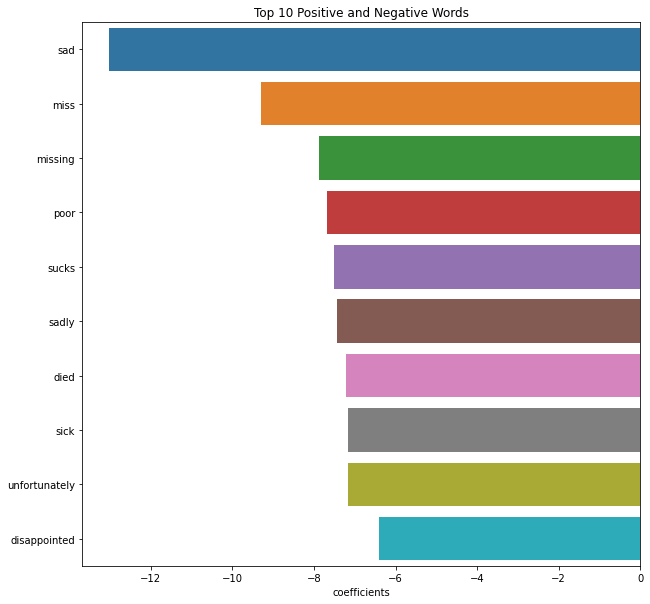

In [20]:
plt.figure(figsize=(10, 10))
sns.barplot(x='coefficients', y=coefficients.sort_values(by='abs', ascending=False).head(10).index, data=coefficients.sort_values(by='abs', ascending=False).head(10))
plt.title('Top 10 Positive and Negative Words')
plt.show()

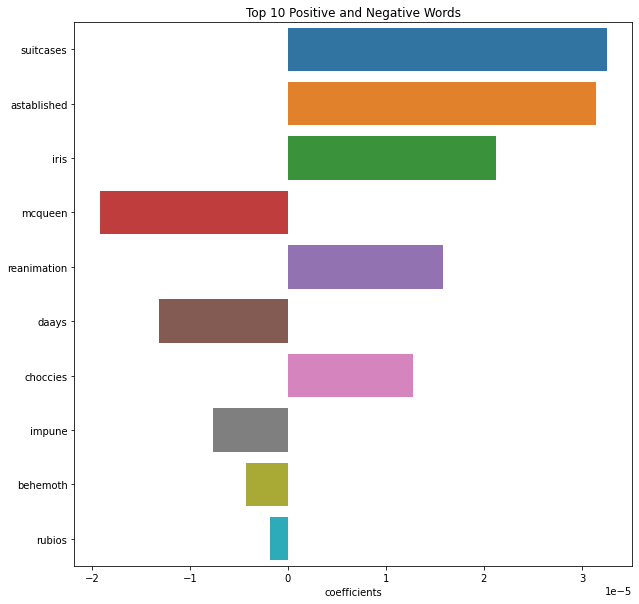

In [21]:
plt.figure(figsize=(10, 10))
sns.barplot(x='coefficients', y=coefficients.sort_values(by='abs', ascending=False).tail(10).index, data=coefficients.sort_values(by='abs', ascending=False).tail(10))
plt.title('Top 10 Positive and Negative Words')
plt.show()